In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
from shutil import copy,SameFileError
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from qiskit_ibm_provider import IBMProvider

from quantum.Quantum import QuantumRegressor
from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import InconsistentVersionWarning

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_17281/1996331647.py:17: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [43]:
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))

    return qml.expval(qml.PauliZ(0))


/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


wires: 16
gates: 160
depth: 55
shots: Shots(total=None)
gate_types:
{'RY': 32, 'RZ': 48, 'CNOT': 32, 'RX': 32, 'CZ': 16}
gate_sizes:
{1: 112, 2: 48}


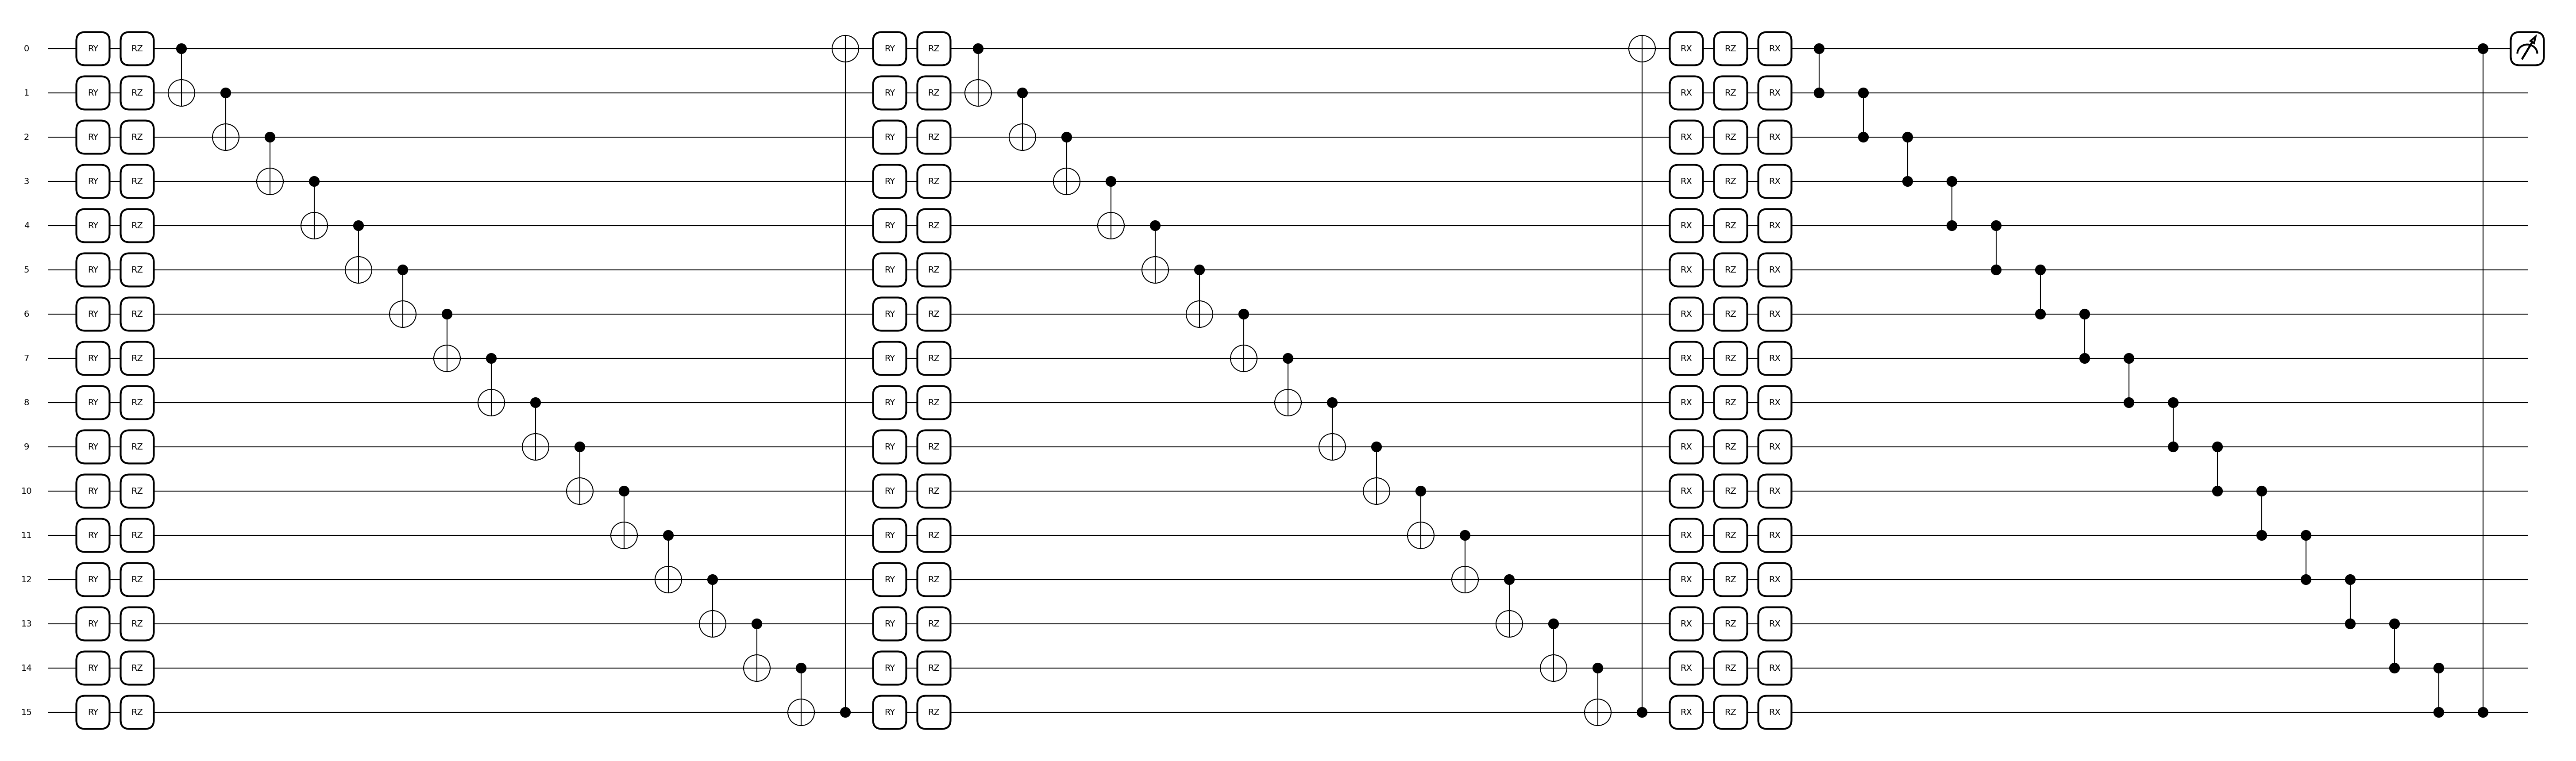

In [44]:
num_qubits=16
re_upload_depth=1
LAYERS=1
# device='qiskit.aer'
# device_backend = FakeCairoV2()
# backend = AerSimulator.from_backend(device_backend)
# device = qml.device(device, wires=num_qubits, backend=backend, shots=shots)


device='qulacs.simulator'
device = qml.device(device, wires=num_qubits)


# encoder=ENCODER_LIST['A2']
# encoder=ENCODER_LIST['M-M-CZ']
encoder=ENCODER_LIST['A2-A2-CNOT']

variational=ANSATZ_LIST['HWE-CZ']
# variational=ANSATZ_LIST['Hadamard']
variational.set_wires(range(num_qubits))
variational.layers = LAYERS


num_params = variational.num_params * re_upload_depth
generator = np.random.default_rng(12958234)
initial_parameters = generator.uniform(-np.pi, np.pi, num_params)

qnode = qml.QNode(circuit, device)

circuit_specs=qml.specs(qnode)(generator.uniform(-1, 1, num_qubits),initial_parameters)

print(circuit_specs['resources'])

qml.draw_mpl(qnode,level=1)(generator.uniform(-1, 1, num_qubits),initial_parameters)
# plt.savefig('trash.png')
plt.show()

In [46]:
7*num_qubits

112

In [49]:
variational.num_params

48

In [51]:
num_params / 16

3.0

In [48]:
2**num_qubits

65536

In [42]:
initial_parameters.shape

(48,)

In [35]:
# Use the 'qml.gradients.param_shift' to compute the gradient tape and extract the trainable params
gradient_fn = qml.gradients.param_shift(circuit)
gradient = gradient_fn(generator.uniform(-1, 1, num_qubits),initial_parameters)

# Count the number of trainable parameters
trainable_params = gradient.tape.trainable_params

# Print the number of trainable parameters
print(f"Number of trainable parameters: {len(trainable_params)}")

TransformError: Impossible to dispatch your transform on quantum function, because more than one tape is returned

In [ ]:
check={}
bad=[]
for ke,ve in ENCODER_LIST.items():
    check[ke]={}
    for ka,va in ANSATZ_LIST.items():
        check[ke][ka]={}
        for i in [1,2]:
            LAYERS=i
            encoder=ve
            
            # variational=ANSATZ_LIST['Full-Pauli-CRZ']
            variational=va
            variational.layers = LAYERS
            variational.set_wires(range(num_qubits))
            
            
            # print(ka,variational.layers)
            num_params = variational.num_params * re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            
            qnode = qml.QNode(circuit, device)
            
            circuit_specs=qml.specs(qnode)(generator.uniform(-1, 1, num_qubits),initial_parameters)
            
            check[ke][ka][i]=circuit_specs['resources'].depth
            
        if check[ke][ka][2]<check[ke][ka][1]:
            # print(ka)
            bad.append(ka)

In [ ]:
check

In [ ]:
for b in set(bad):
    print(ANSATZ_LIST[b])

In [ ]:
set(bad)